In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
submission_df = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
#S is filled in place of nan values in Embarked column as it is where most of the passengers boarded the ship
train_df.Embarked.fillna('S', inplace = True)
test_df.Embarked.fillna('S', inplace = True)

#By grouping the columns by sex and survived or not, I fill in the na values in the age column
train_df.Age = train_df.Age.fillna(train_df.Age.mean())
test_df.Age = test_df.Age.fillna(train_df.Age.mean())
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
132,133,0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.5,NaN,S
735,736,0,3,"Williams, Mr. Leslie",male,28.5,0,0,54636,16.1,NaN,S
607,608,1,1,"Daniel, Mr. Robert Williams",male,27.0,0,0,113804,30.5,NaN,S
624,625,0,3,"Bowen, Mr. David John ""Dai""",male,21.0,0,0,54636,16.1,NaN,S
385,386,0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,S.O.C. 14879,73.5,NaN,S


In [6]:
test_df.Fare.fillna(test_df.Fare.mean(), inplace=True)

In [7]:
#Dropping the Ticket number and Fare column as survival does not depend on those columns
#Also dropping Cabin column as it has more than 60% of nan values and name has nothing to do with the survival as well
train_df.drop(['Cabin', 'Name'], axis = 1, inplace = True)
test_df.drop(['Cabin', 'Name'], axis = 1, inplace = True)


In [8]:
#One Hot Encoding of Embarked Column
encoded_cols = pd.get_dummies(train_df[['Embarked','Sex']]).columns
train_df[encoded_cols] = pd.get_dummies(train_df[['Embarked','Sex']])

encoded_cols = pd.get_dummies(test_df[['Embarked','Sex']]).columns
test_df[encoded_cols] = pd.get_dummies(test_df[['Embarked','Sex']])

In [9]:
input_columns = train_df.select_dtypes(np.number).columns
target_cols = ['Survived']
input_cols = []
for input_column in input_columns:
    if input_column not in target_cols:
        input_cols.append(input_column)
input_cols

['PassengerId',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Sex_female',
 'Sex_male']

In [10]:
inputs = train_df[input_cols]
target = train_df['Survived']

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [12]:
train_x, val_x, train_y, val_y = train_test_split(inputs,target, train_size = 0.33, random_state = 42)

In [13]:
model = RandomForestClassifier(max_depth = 5, random_state=42)

model.fit(train_x, train_y)

predict_train = model.predict(train_x)

accuracy_score(train_y, predict_train)

0.9013605442176871

In [14]:
predict_val = model.predict(val_x)

accuracy_score(val_y, predict_val)

0.8040201005025126

In [15]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'max_depth':np.arange(20),
    'max_leaf_nodes':[16,32,64,128],
    'min_samples_leaf':[10,20,30,40,60,80]
}

randomCV = RandomizedSearchCV(
                estimator=RandomForestClassifier(n_jobs=-1,random_state=42),
                                param_distributions=params,
                                 n_jobs = -1,
                                 random_state=42)
randomCV.fit(train_x, train_y)
randomCV.best_params_

{'min_samples_leaf': 40, 'max_leaf_nodes': 64, 'max_depth': 16}

In [16]:
confusion_matrix(val_y, randomCV.predict(val_x[inputs.columns]))

array([[310,  54],
       [ 72, 161]])

In [17]:
predict_val = randomCV.predict(val_x[inputs.columns])

<AxesSubplot:>

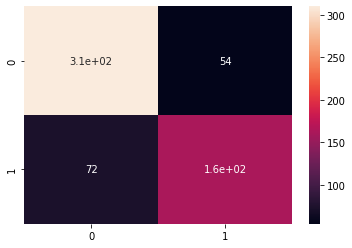

In [18]:
import seaborn as sns
sns.heatmap(confusion_matrix(val_y, predict_val), annot = True)

In [19]:
input = test_df[input_cols]

predict_test = model.predict(input)
predict_test

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [20]:
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predict_test})
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [21]:
output.to_csv('submission.csv', index = False)

In [22]:
#Test Df Predictions  Accuracy - 0.78708